In [265]:
class STLoader:
    def __init__(self, st_path, sample):
        st_df = pd.read_csv(st_path + sample + '_stdata.tsv', sep = '\t', index_col=0, header=0)
        var = pd.DataFrame(st_df.index)
        var.columns = ['gene_ids']
        var.index = st_df.index

        obs = pd.DataFrame(st_df.columns)
        obs.columns = ['feature'] 
        coords = np.array([pos[1:].split('_') for pos in st_df.columns])
        obs['array_row'] = coords[:, 0].astype('float')
        obs['array_col'] = coords[:, 1].astype('float')
        obs['in_tissue'] = 1
        obs['sample'] = sample

        X = np.round(st_df.iloc[:, :].to_numpy().T, 0).astype('int')

        self.array = anndata.AnnData(obs=obs, var=var, X=X)
        self.array.uns['sample'] = sample
        

    def add_image(self, image_path):
        sample = self.array.uns['sample']
        image_path = [image_path + file for file in os.listdir(image_path) if sample in file and '.png' in file][0]
        image = Image.open(image_path)

        self.array.uns['spatial'] = {sample :{'images' :{'hires' :np.asarray(image)}}}
        self.array.uns['spatial'][sample]['scalefactors'] = {'spot_diameter_fullres': 35, 
                                                       'tissue_hires_scalef': max(image.size)/max(image.size),
                                                       'fiducial_diameter_fullres': 35/2.5}
        
        
        X = np.array(self.array.obs.array_row.astype('float'))/max(self.array.obs.array_row.astype('float')) * image.size[0]
        Y = np.array(self.array.obs.array_col.astype('float'))/max(self.array.obs.array_col.astype('float')) * image.size[1]
        
        self.array.obsm['spatial'] = np.stack((X, Y), axis=1)*0.95

In [266]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]  

In [267]:
import scanpy as sc
import os
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import loompy
import pickle

import cell2location
import scvi
from PIL import Image

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFsx

In [203]:
results_folder = './results/multi_mouse_rat_sc/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map' 

In [204]:
st_path = '../../../MNM projects/Spatial transcriptomics project/Data analysis/Complete_ST_pipeline/ST_feature_analysis/data/ST_files/ST_matrix_STARsolo_correct_PetterREFs_Multimap/stdata/'
image_path = '/media/Dropbox/MNM projects/Spatial transcriptomics project/Data analysis/Images_rev1/corrected_png/'
sample  = 'ST3_E1'

st3e1_df = STLoader(st_path, sample)
st3e1_df.add_image(image_path)
st3e1_df.array

/tmp/ipykernel_9417/2199011833.py:18: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.array = anndata.AnnData(obs=obs, var=var, X=X)
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 930 × 13690
    obs: 'feature', 'array_row', 'array_col', 'in_tissue', 'sample'
    var: 'gene_ids'
    uns: 'sample', 'spatial'
    obsm: 'spatial'

In [206]:
adata_vis = st3e1_df.array.copy()

In [209]:
## load single cell data 
sc_path = '/media/Dropbox/MNM projects/Spatial transcriptomics project/Data analysis/Complete_ST_pipeline/stereoscope_deconvolution/stereoscope/data/single_cell_data/curated/Linnarsson_VM-STR-Ctx-selection_23082021/'
filename = sc_path.split('/')[-2] + '.pkl'
    
if '.pkl' not in str(os.listdir(sc_path)):
    print('new anndata')
    sc_obs = pd.read_csv(sc_path + [file for file in os.listdir(sc_path) if 'mta_data' in file][0], sep='\t', 
                     header=0, 
                     index_col=False)
    sc_obs.index = sc_path.split('/')[-2] + '_' + sc_obs['cell']
    
    sc_cnt = pd.read_csv(sc_path + [file for file in os.listdir(sc_path) if 'cnt_data' in file][0], sep='\t',
                    index_col=0,
                    header=0)
    
    sc_var = pd.DataFrame(sc_cnt.columns)
    sc_var.columns = ['SYMBOL']
    sc_var.index = sc_var['SYMBOL']
    
    sc_adata = anndata.AnnData(obs=sc_obs, var=sc_var, X = sc_cnt.iloc[:,:].to_numpy())
    

    outfile = open(sc_path + filename,'wb')
    pickle.dump(sc_adata, outfile)
    outfile.close()
else:
    print('found a pickle!')
    infile = open(sc_path + filename,'rb')
    sc_adata = pickle.load(infile)
    infile.close()

found a pickle!


In [210]:
sc_adata.obs['Sample'] = 'Linnarsson'

/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


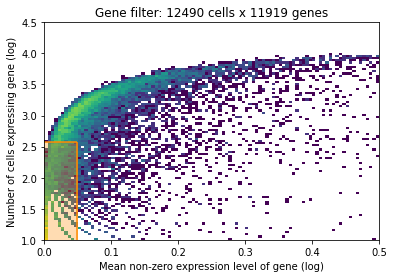

In [211]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

# Read data
adata_ref = sc_adata.copy()

from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [212]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='bio_celltype'
                       )
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.3.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'bio_celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 12490 │
│          n_vars          │ 11919 │
│         n_batch          │   1   │
│         n_labels         │  29   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │ Linnarsson │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                                    labels State Registry                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Source Locati ┃                            Categories                            ┃ scvi-t ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ adata.obs['bi │              Axo-axonic, cortex/hippocampus (decoy)              │   0    │
│               │    Basket and bistratified cells, cortex/hippocampus (decoy)     │   1    │
│               │ CGE-derived neurogliaform cells Cxcl14+, cortex/hippocampus (dec │   2    │
│               │   CGE-derived neurogliaform cells, cortex/hippocampus (decoy)    │   3    │
│               │                 Cholinergic interneurons; mouse                  │   4    │
│               │        Cholinergic neurons, midbrain red nucleus (decoy)         │   5    │
│               │                Cortical projection neurons; mouse                │   6    │
│               │                  D1 Medium Spiny Neurons; mouse                  │   7    │
│               │                  D2 Medium Spiny Neurons; mouse                  │   8    │
│               │                   Dopaminergic neurons; mouse                    │   9    │
│               │     Hippocamposeptal projection, cortex/hippocampus (decoy)      │   10   │
│               │                       Immune cells; mouse                        │   11   │
│               │               Inhibitory neurons, midbrain (decoy)               │   12   │
│               │            Inhibitory neurons, septal nucleus (decoy)            │   13   │
│               │  Interneuron-selective interneurons, cortex/hippocampus (decoy)  │   14   │
│               │ Ivy and MGE-derived neurogliaform cells, cortex/hippocampus (dec │   15   │
│               │          Neuronal intermidate progenitor cells (decoy)           │   16   │
│               │     Non-border Cck interneurons, cortex/hippocampus (decoy)      │   17   │
│               │           Non-telencephalon astrocytes, fibrous; mouse           │   18   │
│               │        Non-telencephalon astrocytes, protoplasmic; mouse         │   19   │
│               │                     Oligodendrocytes; mouse                      │   20   │
│               │              Patch D1/D2 neurons, striatum (decoy)               │   21   │
│               │     R-LM border Cck interneurons, cortex/hippocampus (decoy)     │   22   │
│               │ Sleep-active, long-range projection interneurons, cortex/hippoca │   23   │
│               │            Subventricular zone radial glia-like cells            │   24   │
│               │             Telencephalon astrocytes, fibrous; mouse             │   25   │
│               │          Telencephalon astrocytes, protoplasmic; mouse           │   26   │
│               │               Vascular leptomeningeal cells; mouse               │   27   │
│               │                         Vascular; mouse                          │   28   │
└───────────────┴──────────────────────────────────────────────────────────────────┴────────┘

In [213]:
mod.train(max_epochs=250, use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2/250:   0%|           | 1/250 [00:01<07:06,  1.71s/it, v_num=1, elbo_train=6.83e+7]

/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 250/250: 100%|███████| 250/250 [07:08<00:00,  1.72s/it, v_num=1, elbo_train=6.64e+7]


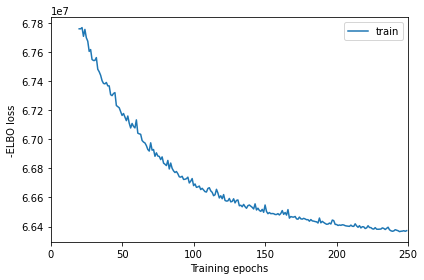

In [214]:
mod.plot_history(20)

In [215]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|████████████████| 999/999 [00:20<00:00, 47.58it/s]


'./results/mouse_rat_sc//reference_signatures/sc.h5ad'

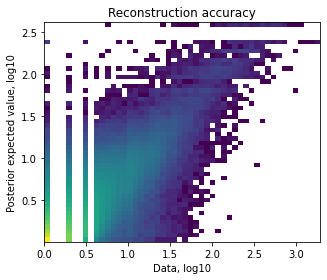

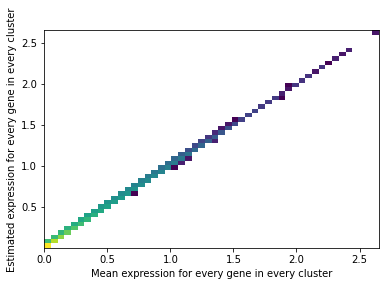

In [216]:
mod.plot_QC()

In [217]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File ./results/mouse_rat_sc//reference_signatures/model.pt already downloaded       
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/1000:   0%|         | 1/1000 [00:01<22:07,  1.33s/it, v_num=1, elbo_train=6.89e+7]


/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [218]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

Axo-axonic, cortex/hippocampus (decoy)  \
SYMBOL                                                  
0610007P14RIK                                0.503691   
0610009B22RIK                                0.472946   
0610009L18RIK                                0.193998   
0610009O20RIK                                0.108096   
0610010F05RIK                                0.153274   

               Basket and bistratified cells, cortex/hippocampus (decoy)  \
SYMBOL                                                                     
0610007P14RIK                                           0.430327           
0610009B22RIK                                           0.472328           
0610009L18RIK                                           0.205824           
0610009O20RIK                                           0.121152           
0610010F05RIK                                           0.172866           

               CGE-derived neurogliaform cells Cxcl14+, cortex/hippocampus (decoy)  \
SYMBOL                                                                               
0610007P14RIK                                           0.556809                     
0610009B22RIK                                           0.420015                     
0610009L18RIK                                           0.072813                     
0610009O20RIK                                           0.144551                     
0610010F05RIK                                           0.091652                     

               CGE-derived neurogliaform cells, cortex/hippocampus (decoy)  \
SYMBOL                                                                       
0610007P14RIK                                           0.598756             
0610009B22RIK                                           0.468222             
0610009L18RIK                                           0.106581             
0610009O20RIK                                           0.082763             
0610010F05RIK                                           0.075212             

               Cholinergic interneurons; mouse  
SYMBOL                                          
0610007P14RIK                         0.578937  
0610009B22RIK                         1.181304  
0610009L18RIK                         0.231790  
0610009O20RIK                         0.169341  
0610010F05RIK                         0.617486

In [219]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [220]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=50,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │  930  │
│          n_vars          │ 9218  │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │   ST3_E1   │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 3/30000:   0%|     | 2/30000 [00:00<1:27:40,  5.70it/s, v_num=1, elbo_train=1.09e+7]

/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 30000/30000: 100%|█| 30000/30000 [1:19:18<00:00,  6.30it/s, v_num=1, elbo_train=7.01


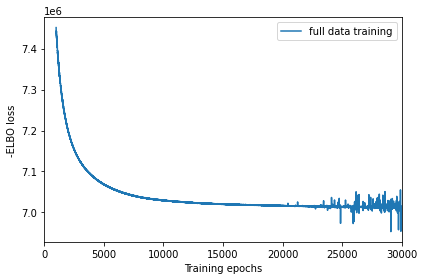

In [222]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [223]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|████████████████| 999/999 [00:33<00:00, 29.79it/s]


'./results/mouse_rat_sc//cell2location_map/sp.h5ad'

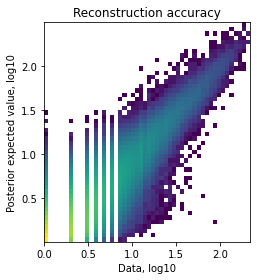

In [224]:
mod.plot_QC()

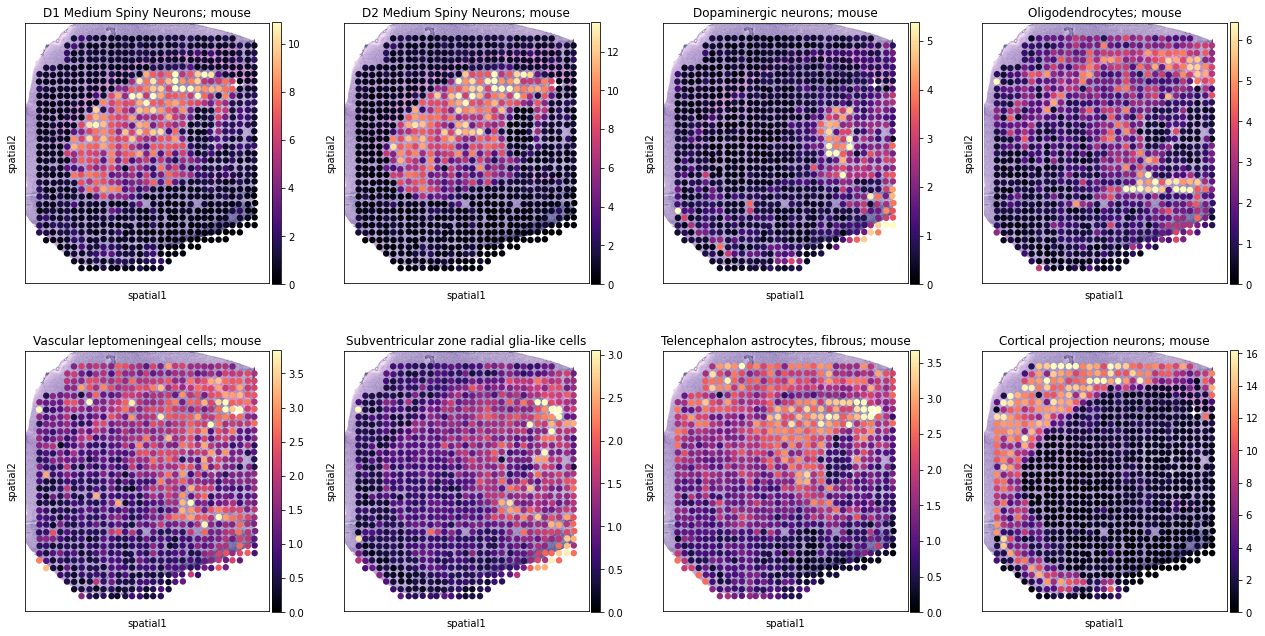

In [263]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'ST3_E1')

# plot in spatial coordinates
with mpl.rc_context({'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['D1 Medium Spiny Neurons; mouse', 'D2 Medium Spiny Neurons; mouse', 
                         'Dopaminergic neurons; mouse', 'Oligodendrocytes; mouse',
                         'Vascular leptomeningeal cells; mouse', 'Subventricular zone radial glia-like cells', 
                         'Telencephalon astrocytes, fibrous; mouse', 'Cortical projection neurons; mouse'],
                  ncols=4, size=1.3,                   
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

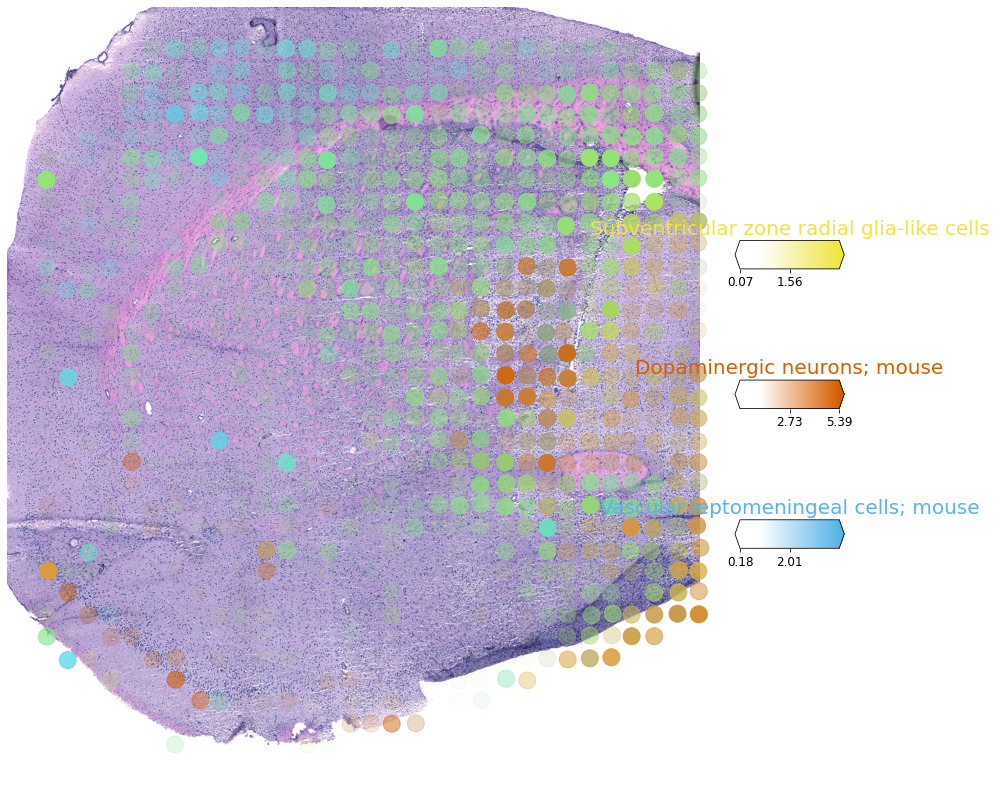

In [271]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['Subventricular zone radial glia-like cells', 
                'Dopaminergic neurons; mouse', 
                'Vascular leptomeningeal cells; mouse']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'ST3_E1')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=17,
        colorbar_position='right'
    )



In [272]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

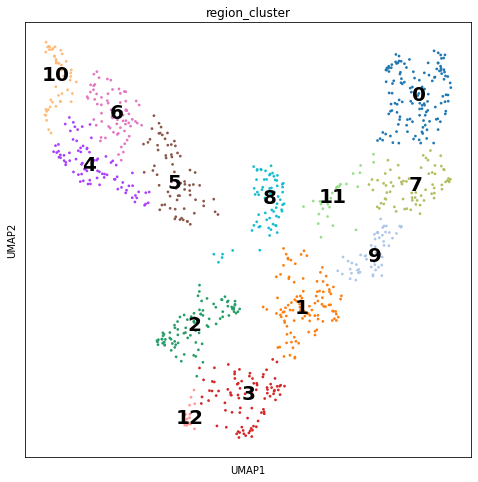

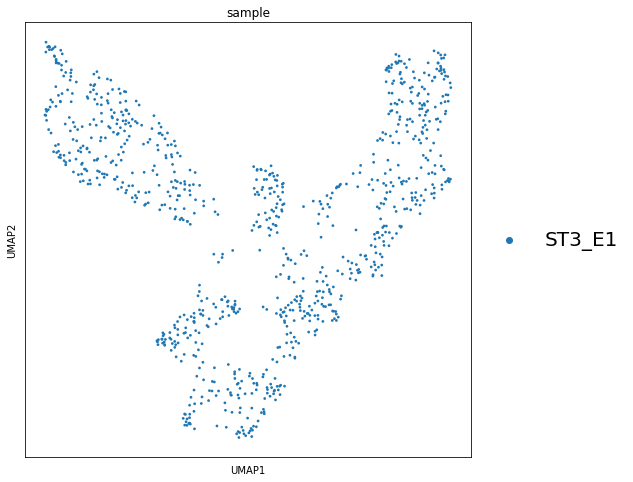

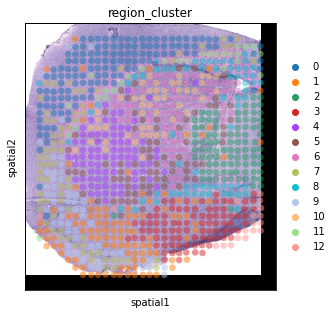

In [273]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)

In [274]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_930locations_29factors


/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_930locations_29factors


/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


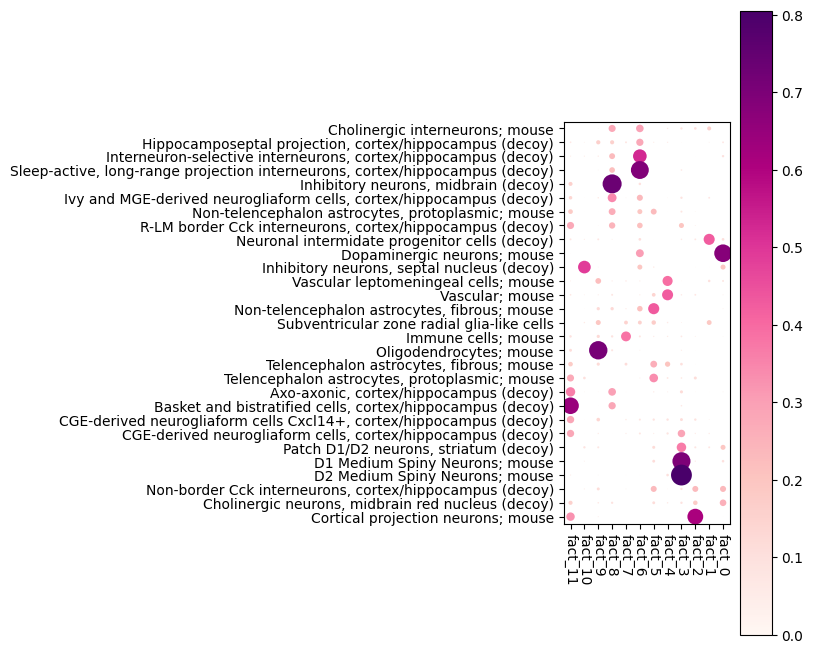

In [275]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()

In [276]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'./results/mouse_rat_sc//cell2location_map/sp.h5ad'

In [285]:
adata_vis.var

SYMBOL  MT_gene
gene_ids                             
5330417C22RIK  5330417C22RIK    False
A2M                      A2M    False
AACS                    AACS    False
AAGAB                  AAGAB    False
AAK1                    AAK1    False
...                      ...      ...
ZXDC                    ZXDC    False
ZYG11B                ZYG11B    False
ZYX                      ZYX    False
ZZEF1                  ZZEF1    False
ZZZ3                    ZZZ3    False

[9218 rows x 2 columns]

In [289]:
adata_vis.obsm['spatial'] = adata_vis.obsm['spatial']*0.95

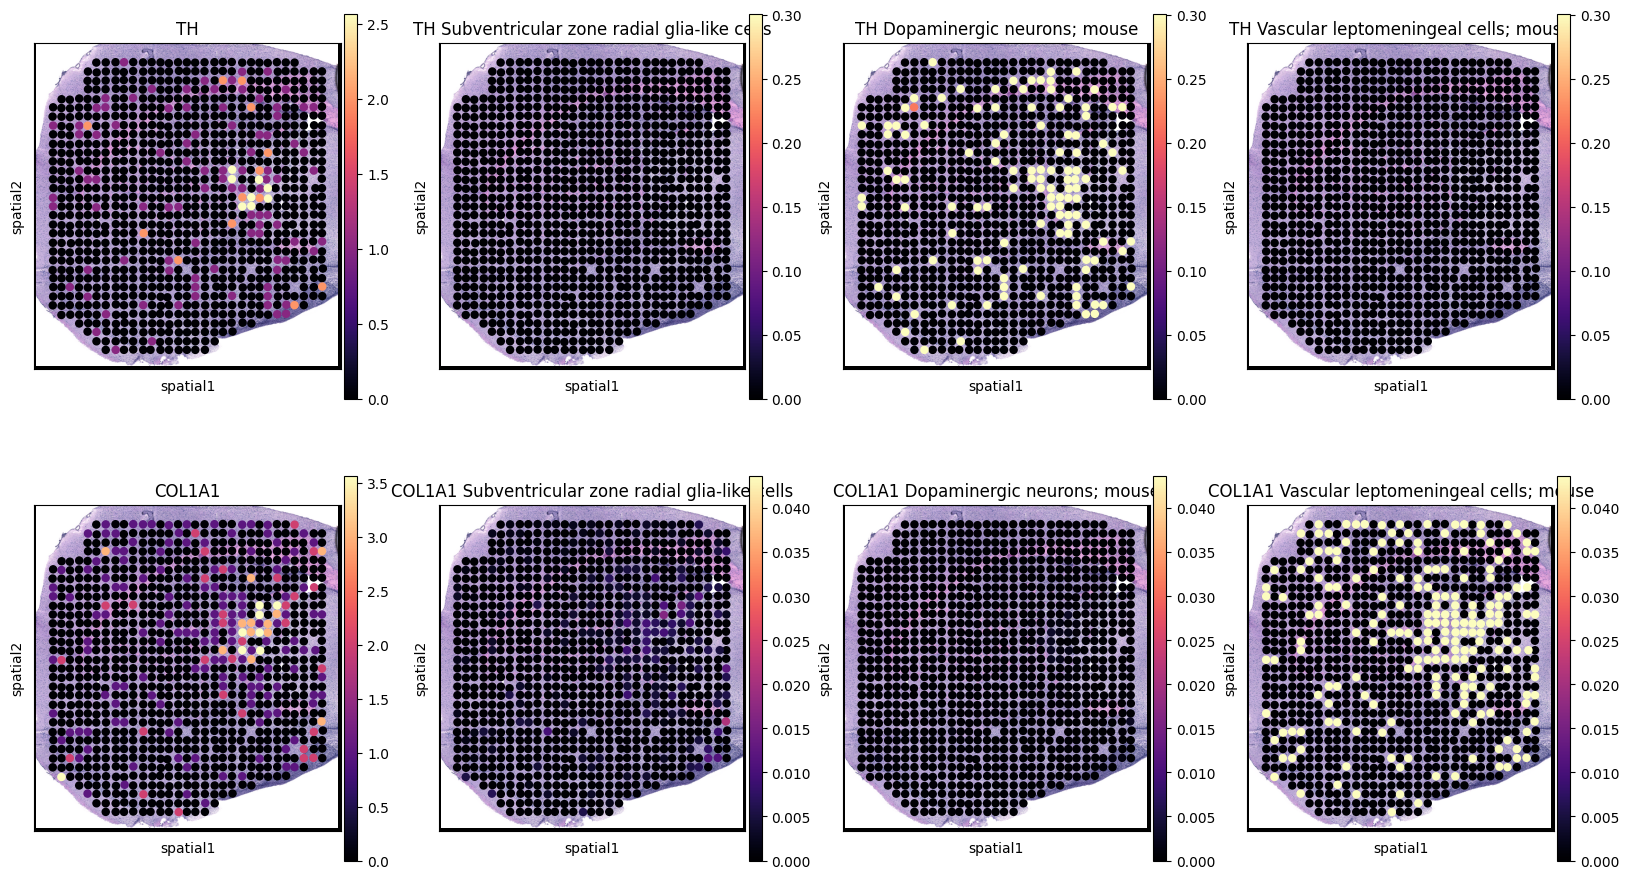

In [290]:
# list cell types and genes for plotting
ctypes = ['Subventricular zone radial glia-like cells', 
                'Dopaminergic neurons; mouse', 
                'Vascular leptomeningeal cells; mouse']
genes = ['TH', 'COL1A1']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis, 'ST3_E1')

    from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes);